In [38]:
import requests
import io
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier

from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings("ignore")

In [39]:
def get_keys(path):
    with open(path) as f:
        return f.readlines()[0]

In [40]:
def get_historical_stock_price(ticker, interval = None, startDate = None, endDate = None):
    url = 'https://api.unibit.ai/v2/stock/historical?'

    ticker_dict = {
        'tickers' : ticker,
        'interval' : interval,
        'startDate' : startDate,
        'endDate' : endDate,
        'selectedFields' : None,
        'dataType':'json',
        'accessKey': get_keys('C:\\Users\\TJ Bray\.secret\\unibit.txt')
    }
    
    response = requests.get(url, params = ticker_dict)
    data = response.json()['result_data'][ticker]
    df = pd.json_normalize(data)
    
    return df

In [41]:
#NKE = get_historical_stock_price('NKE', startDate = '2021-1-1', endDate = '2022-1-7')
#NKE.to_csv('nike.csv')

In [42]:
#nike = pd.read_csv('nike.csv', index_col = 0)
#nike.date = pd.to_datetime(nike.date)
#nike.set_index('date', inplace = True)
#nike.sort_index(inplace = True)

In [43]:
#files = [f for f in listdir('.\S&P500_data')]

In [44]:
#companies = []
#for i in files:
    #company = i.split('.')[0]
    #companies.append(company)

In [45]:
#test_companies = np.random.choice(companies, 5)

In [46]:
#x = test_companies[0]
x = 'AMZN'

In [47]:
csv_for_df = f'S&P500_data/{x}.csv'
df = pd.read_csv(csv_for_df)
df.columns = [i.lower().replace(' ',"") for i in df.columns]

In [48]:
df['date'] = pd.to_datetime(df.date, format = '%d-%m-%Y')
df.set_index('date', inplace = True)
df.sort_index(inplace = True)

In [49]:
df['rsi'] = ta.rsi(df.close)

In [50]:
def add_bbands(df):
    bbands = ta.bbands(df.close)
    df = df.join(bbands)
    return df

In [51]:
bbands_df = add_bbands(df)

In [52]:
def add_sma(df):
    
    sma_days = [7,22,50,252]
    
    for i in sma_days:
        name = f'sma{i}'
        df[name] = ta.sma(df['close'],i)
        
    return df

In [53]:
sma_df = add_sma(bbands_df)

In [54]:
def add_ema(df):

    ema_days = [7,22,50,252]

    for i in ema_days:
        name = f'ema{i}'
        df[name] = ta.ema(df['close'],i)
        
    for i in ema_days:
        zone_name = f'ema{i}zone'
        df[zone_name] = ta.ema(df.high,i) - ta.ema(df.low,i)
        
    return df

In [55]:
ema_df = add_ema(sma_df)

In [56]:
df = ema_df

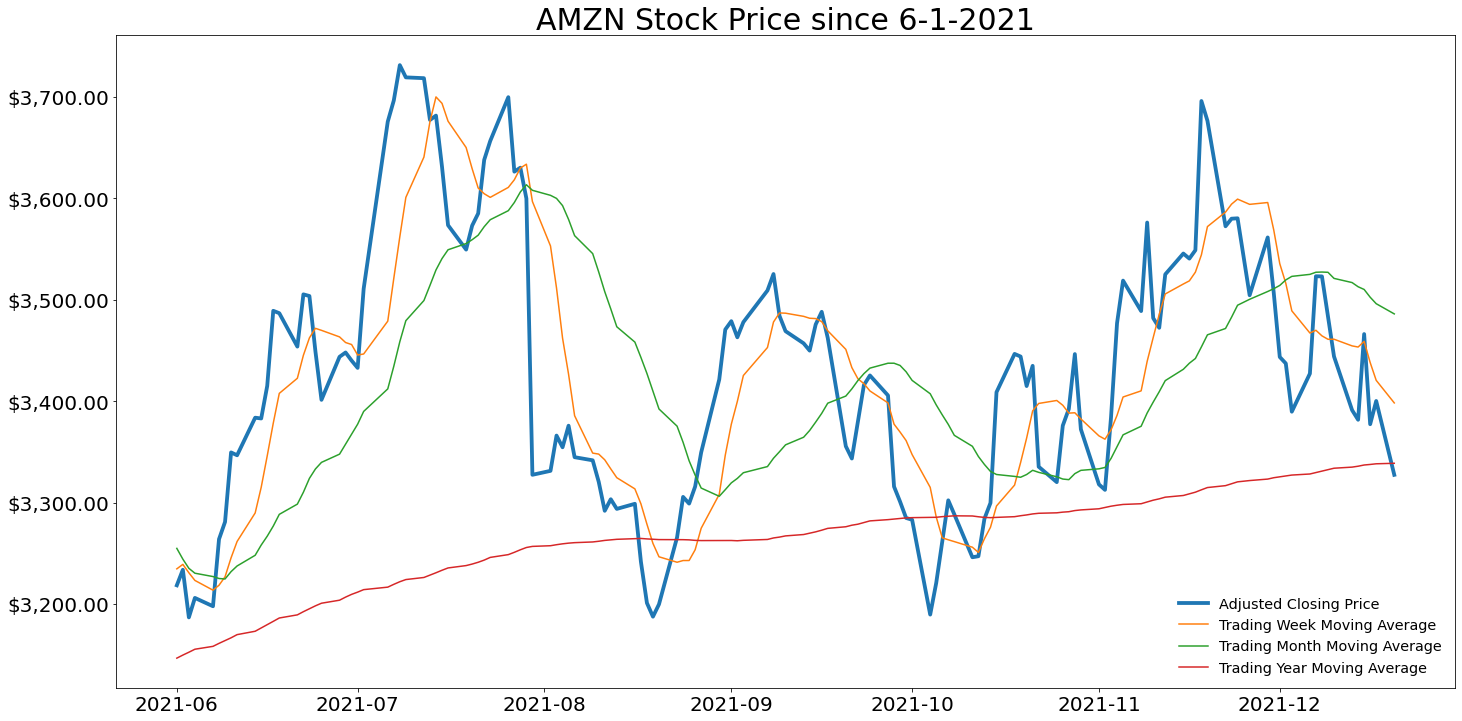

In [57]:
date = '6-1-2021'
title = f'{x} Stock Price since {date}'

plotdata = df[df.index >= date]
fig, ax = plt.subplots(figsize = (24,12))
ax.plot(plotdata.adjustedclose, linewidth = 3.8)
ax.plot(plotdata.sma7)
ax.plot(plotdata.sma22)
ax.plot(plotdata.sma252)
ax.yaxis.set_major_formatter('${x:1,.2f}')
ax.legend(['Adjusted Closing Price', 'Trading Week Moving Average', 'Trading Month Moving Average', 'Trading Year Moving Average'],
         fontsize = 'x-large', edgecolor = '1')
ax.set_title(title, fontsize = '30')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')

plt.show()

In [58]:
#Explain Bollinger Bands and Importance

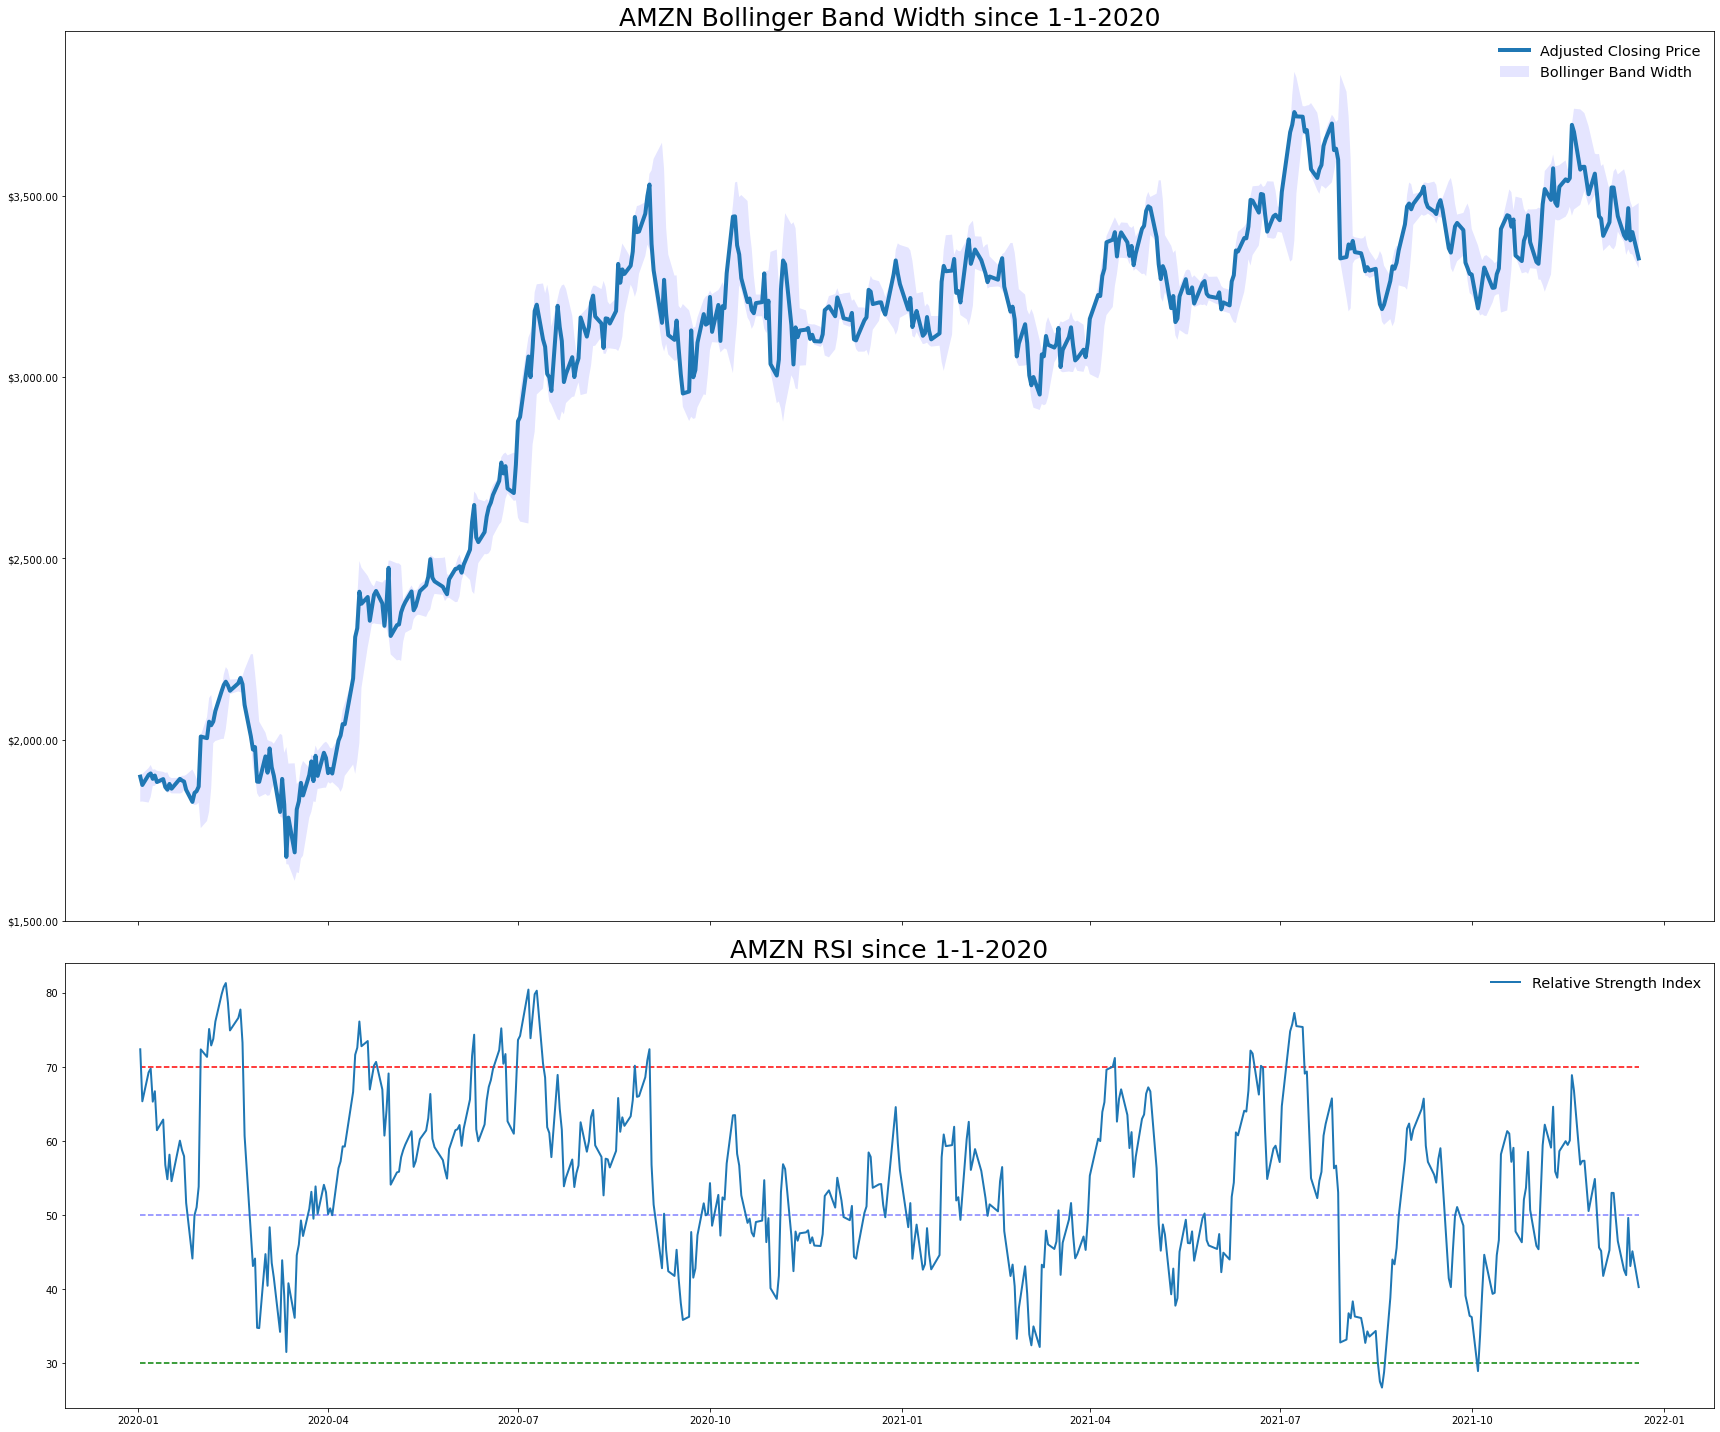

In [59]:
date = '1-1-2020'
title1 = f'{x} Bollinger Band Width since {date}'
title2 = f'{x} RSI since {date}'
plotdata = df[df.index >= date]

fig, (ax1, ax2) = plt.subplots(2, figsize = (24,20), sharex = True, gridspec_kw = {'height_ratios': [2,1]})
ax1.plot(plotdata.adjustedclose, linewidth = 4)
ax1.fill_between(plotdata.index, plotdata['BBL_5_2.0'], plotdata['BBU_5_2.0'], facecolor = 'blue', alpha = .1)
ax1.yaxis.set_major_formatter('${x:1,.2f}')
ax1.legend(['Adjusted Closing Price', 'Bollinger Band Width'],
         fontsize = 'x-large', edgecolor = '1')
ax1.set_title(title1, fontsize = '25')

ax2.plot(plotdata.rsi, linewidth = 2)
ax2.hlines(y=70, linestyle = "--", xmin =plotdata.index.min(), xmax =plotdata.index.max(), alpha = 1, color = 'red')
ax2.hlines(y=50, linestyle = "--", xmin =plotdata.index.min(), xmax =plotdata.index.max(), alpha = .5, color = 'blue')
ax2.hlines(y=30, linestyle = "--", xmin =plotdata.index.min(), xmax =plotdata.index.max(), alpha = 1, color = 'green')
ax2.legend(['Relative Strength Index'],
         fontsize = 'x-large', edgecolor = '1')
ax2.set_title(title2, fontsize = '25')

plt.tight_layout()
plt.show()

In [60]:
#Explain RSI and Importance

In [61]:
#lags = [1,2,3,4,5,10]

#for i in lags:
#    lag_time = f'closelag{i}'
#    df[lag_time] = df['adjustedclose'].shift(i)

In [62]:
df['day_direction'] = np.where(df['adjustedclose'] > df['adjustedclose'].shift(1),1,0)

In [63]:
df['golden_crossover_short'] = np.where((df['ema50'] < df['ema7']) & (df['ema50'].shift(1) > df['ema7'].shift(1)),1,0) 

In [64]:
df['death_crossover_short'] = np.where((df['ema50'] > df['ema7']) & (df['ema50'].shift(1) < df['ema7'].shift(1)),1,0) 

In [65]:
df['golden_crossover_long'] = np.where((df['ema252'] < df['ema50']) & (df['ema252'].shift(1) > df['ema50'].shift(1)),1,0) 

In [66]:
df['death_crossover_long'] = np.where((df['ema252'] > df['ema50']) & (df['ema252'].shift(1) < df['ema50'].shift(1)),1,0) 

In [67]:
df['RSI_overbought_cross'] = np.where((df['rsi'] >= 70) & (df['rsi'].shift(1) < 70),1,0)

In [68]:
df['RSI_oversold_cross'] = np.where((df['rsi'] <= 30) & (df['rsi'].shift(1) > 30),1,0)

In [69]:
df['RSI_overbought'] = np.where(df['rsi'] >= 70,1,0)

In [70]:
df['RSI_oversold'] = np.where(df['rsi'] <= 30,1,0)

In [71]:
df['momentum'] = ta.mom(df['adjustedclose'])

In [72]:
macro = pd.read_csv('macro_daily.csv', index_col = 0)

In [73]:
df = df.join(macro)

In [74]:
csv_name = f'{x}_formatted.csv'
df.to_csv(csv_name)